# 树模型入门与实战

原文链接：[A Practical Guide to Tree Based Learning Algorithms](https://sadanand-singh.github.io/posts/treebasedmodels/)

我们利用 Kaggle 上的 [US Income dataset available at Kaggle](https://www.kaggle.com/johnolafenwa/us-census-data) 数据来进行树模型的演示。

In [1]:
# Imports
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
training_data_file = '../input/adult-training.csv'
test_data_file = '../input/adult-test.csv'

columns = ['Age','Workclass','fnlgwt','Education','EdNum','MaritalStatus',
           'Occupation','Relationship','Race','Sex','CapitalGain','CapitalLoss',
           'HoursPerWeek','Country','Income']

df_train_set = pd.read_csv(training_data_file, names=columns)
df_test_set = pd.read_csv(test_data_file, names=columns, skiprows=1)

In [3]:
df_train_set.info()
df_test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age              32561 non-null int64
Workclass        32561 non-null object
fnlgwt           32561 non-null int64
Education        32561 non-null object
EdNum            32561 non-null int64
MaritalStatus    32561 non-null object
Occupation       32561 non-null object
Relationship     32561 non-null object
Race             32561 non-null object
Sex              32561 non-null object
CapitalGain      32561 non-null int64
CapitalLoss      32561 non-null int64
HoursPerWeek     32561 non-null int64
Country          32561 non-null object
Income           32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
Age              16281 non-null int64
Workclass        16281 non-null object
fnlgwt           16281 non-null int64
Education        16281 non-null object

可以看到数据质量非常好，没有缺失值。其中训练集和测试集均为15列，其中核心列是`Income`列，也是我们要预测的结果列。

In [4]:
df_train_set.head()

,Age,Workclass,fnlgwt,Education,EdNum,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# 由于 fnlgwt 列没有意义，因此去掉该列
df_train_set.drop('fnlgwt', axis=1, inplace=True)
df_test_set.drop('fnlgwt', axis=1, inplace=True)

In [6]:
# 将特殊字符均替换为"Unknown"
for i in df_train_set.columns:
    df_train_set[i].replace(' ?', 'Unknown', inplace=True)
    df_test_set[i].replace(' ?', 'Unknown', inplace=True)

for col in df_train_set.columns:
    if df_train_set[col].dtype != 'int64': # 数值形式的变量无需处理
        df_train_set[col] = df_train_set[col].apply(lambda val: val.replace(" ", ""))
        df_train_set[col] = df_train_set[col].apply(lambda val: val.replace(".", ""))
        df_test_set[col] = df_test_set[col].apply(lambda val: val.replace(" ", ""))
        df_test_set[col] = df_test_set[col].apply(lambda val: val.replace(".", ""))

In [7]:
df_train_set.head(10)

,Age,Workclass,Education,EdNum,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,Country,Income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [8]:
# Country 列对收入影响不大，去掉
# Education 和 EdNum 强相关，保留 EdNum，去掉 Education 列
df_train_set.drop(["Country", "Education"], axis=1, inplace=True)
df_test_set.drop(["Country", "Education"], axis=1, inplace=True)

In [9]:
# 将 Age 按间隔为10年分组
# 将 EdNum 按间隔为5分组
colnames = list(df_train_set.columns)
colnames.remove('Age')
colnames.remove('EdNum')
colnames = ['AgeGroup', 'Education'] + colnames

labels = ["{0}-{1}".format(i, i + 9) for i in range(0, 100, 10)]
df_train_set['AgeGroup'] = pd.cut(df_train_set.Age, range(0, 101, 10), right=False, labels=labels)
df_test_set['AgeGroup'] = pd.cut(df_test_set.Age, range(0, 101, 10), right=False, labels=labels)

labels = ["{0}-{1}".format(i, i + 4) for i in range(0, 20, 5)]
df_train_set['Education'] = pd.cut(df_train_set.EdNum, range(0, 21, 5), right=False, labels=labels)
df_test_set['Education'] = pd.cut(df_test_set.EdNum, range(0, 21, 5), right=False, labels=labels)

df_train_set = df_train_set[colnames]
df_test_set = df_test_set[colnames]

In [10]:
df_train_set.Income.value_counts()

<=50K    24720
>50K      7841
Name: Income, dtype: int64

In [11]:
df_test_set.Income.value_counts()

<=50K    12435
>50K      3846
Name: Income, dtype: int64

对`Income`的分析可知，薪水<=50K的数据约为>50K数据的三倍，但在下面的分析中不考虑数据的不平衡。

利用 Python 中的`plotnine`包进行探索性数据分析，该包模拟 R 语言中的`ggplot`，语法基本一致，可以视为`ggplot`在 Python 中的一个较好的实现。

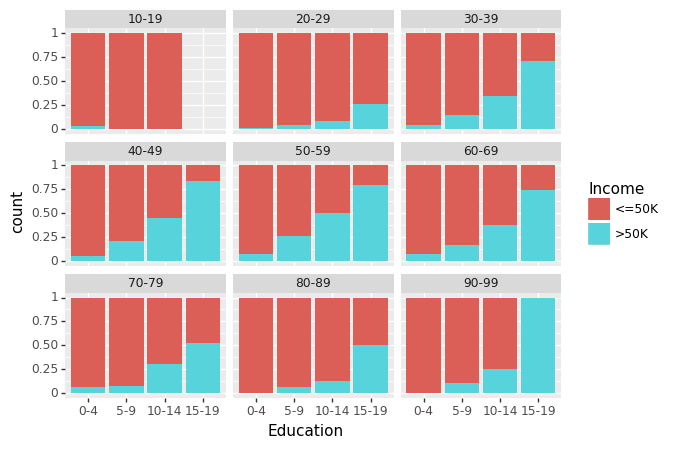

<ggplot: (286579271)>

In [12]:
(ggplot(df_train_set, aes(x = "Education", fill = "Income"))
 + geom_bar(position="fill")
 + facet_wrap('~AgeGroup')
)

可以看出教育程度越高，即 EdNum 越大，高收入的比例越高——知识改变命运。

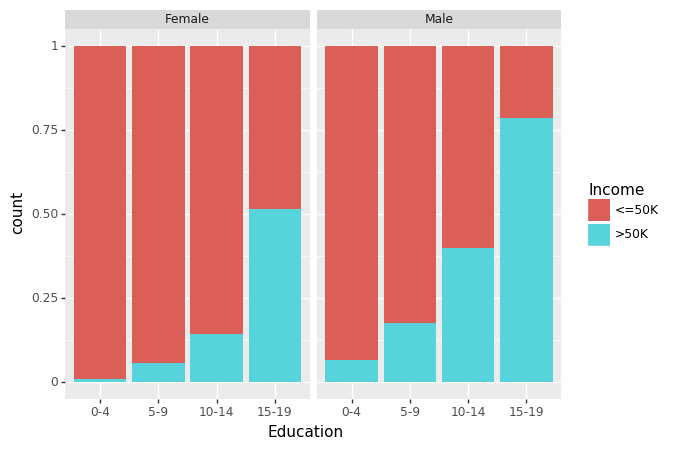

<ggplot: (-9223372036567561980)>

In [13]:
(ggplot(df_train_set, aes(x = "Education", fill = "Income"))
 + geom_bar(position="fill")
 + facet_wrap('~Sex')
)

相同教育水平情况下，男性高收入比例明显高于女性高收入比例。

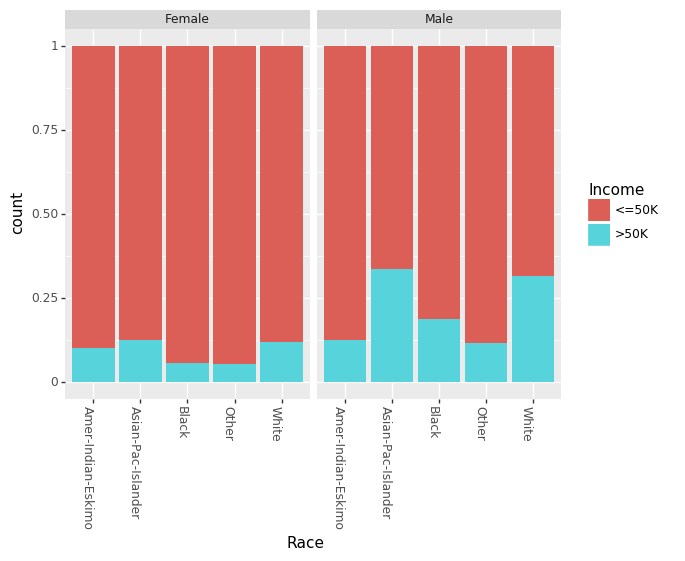

<ggplot: (287213839)>

In [14]:
(ggplot(df_train_set, aes(x = "Race", fill = "Income"))
 + geom_bar(position="fill")
 + theme(axis_text_x = element_text(angle = -90, hjust = 1))
 + facet_wrap('~Sex')
)

白人和亚裔高收入比例教高，同时男女之间差异明显。

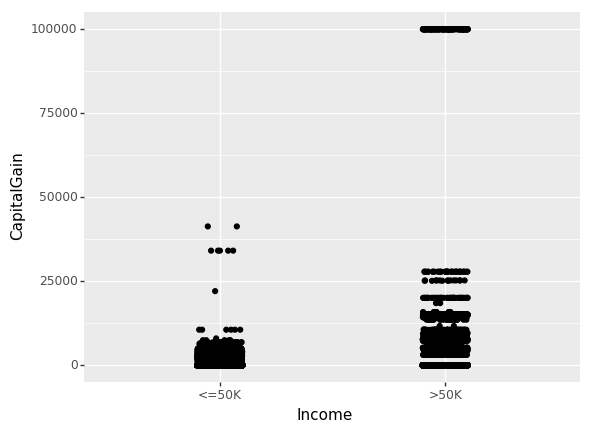

<ggplot: (-9223372036577439814)>

In [15]:
(ggplot(df_train_set, aes(x="Income", y="CapitalGain"))
 + geom_jitter(position=position_jitter(0.1))
)

高收入群体的`CapitalGain`呈两极分化，总体高于低收入群体。

## **决策树**
利用`sklearn`中的`sklearn.tree.DecisionTreeClassifier`生成决策树，注意需要先把字符串型变量转为数值型变量。

In [16]:
# 字符串型转为数值型并编码
mapper = DataFrameMapper([
    ('AgeGroup', LabelEncoder()),
    ('Education', LabelEncoder()),
    ('Workclass', LabelEncoder()),
    ('MaritalStatus', LabelEncoder()),
    ('Occupation', LabelEncoder()),
    ('Relationship', LabelEncoder()),
    ('Race', LabelEncoder()),
    ('Sex', LabelEncoder()),
    ('Income', LabelEncoder())
], df_out=True, default=None)

cols = list(df_train_set.columns)
cols.remove("Income")
cols = cols[:-3] + ["Income"] + cols[-3:]

df_train = mapper.fit_transform(df_train_set.copy())
df_train.columns = cols

df_test = mapper.transform(df_test_set.copy())
df_test.columns = cols

cols.remove("Income")
x_train, y_train = df_train[cols].values, df_train["Income"].values
x_test, y_test = df_test[cols].values, df_test["Income"].values

In [17]:
df_train.head()

,AgeGroup,Education,Workclass,MaritalStatus,Occupation,Relationship,Race,Sex,Income,CapitalGain,CapitalLoss,HoursPerWeek
0,2,1,6,4,0,1,4,1,0,2174,0,40
1,4,1,5,2,3,0,4,1,0,0,0,13
2,2,3,3,0,5,1,4,1,0,0,0,40
3,4,3,3,2,5,0,2,1,0,0,0,40
4,1,1,3,2,9,5,2,0,0,0,0,40


可以看到所有的字符串变量均转换为数值变量。

In [18]:
treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(x_train, y_train) # 训练决策树
test_score = treeClassifier.score(x_test, y_test) # 测试集上的得分

print('{0}%'.format(test_score*100))

83.49609974817271%


默认参数的决策树在测试集上的分类正确率为**83.55%**。下面我们采用混淆矩阵来判断模型的优劣。

In [19]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    本函数用于做出混淆矩阵图
    """
    cmap = plt.cm.Blues
    title = 'Confusion Matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

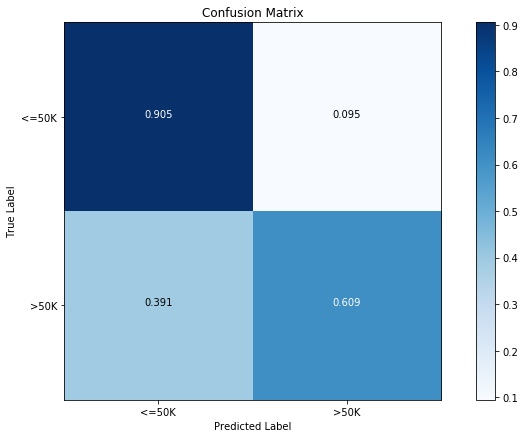

In [20]:
y_pred = treeClassifier.predict(x_test)
cfm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["<=50K", ">50K"], normalize=True)

可以看到低收入群体的分类正确率高达**90.6%**，但高收入群体的分类正确率仅为**60.8%**，由于测试集中低收入数据较多，因此总体表现为**83.54%**。

为获得更好的预测效果，需要对决策树的参数进行优化调整。我们采用`sklearn`中的`GridSearchCV()`函数进行5折交叉验证来调参。

In [21]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'max_features':(None, 9, 6),
     'max_depth':(None, 24, 16),
     'min_samples_split': (2, 4, 8),
     'min_samples_leaf': (16, 4, 12)
}

clf = GridSearchCV(treeClassifier, parameters, cv=5, n_jobs=4)
clf.fit(x_train, y_train)
clf.best_score_, clf.score(x_test, y_test), clf.best_params_

(0.85918737139522738,
 0.85682697622996129,
 {'max_depth': 16,
  'max_features': 6,
  'min_samples_leaf': 12,
  'min_samples_split': 2})

可以看到调参后，决策树的分类正确率上升为**85.95%**，仍然采用混淆矩阵来评价调参后的最优模型。

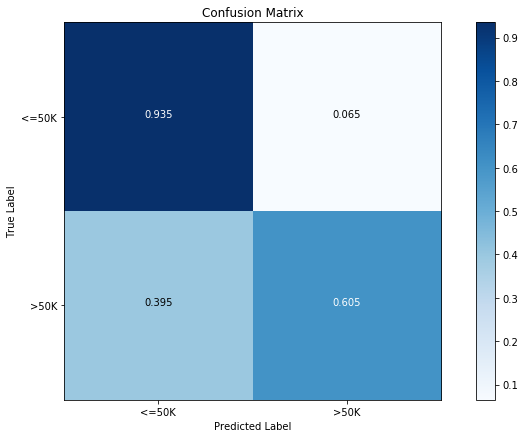

In [22]:
y_pred = clf.predict(x_test)
cfm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["<=50K", ">50K"], normalize=True)

可以看到低收入和高收入群体的分类正确率都有一定的提升。

## **随机森林模型(Random Forest Model)**
采用`sklearn`自带的随机森林模型进行预测，默认参数为使用500个决策树。

In [23]:
rclf = RandomForestClassifier(n_estimators=500)
rclf.fit(x_train, y_train)
rf_score = rclf.score(x_test, y_test)

print('{0}%'.format(rf_score*100))

85.07462686567165%


可以看到初始参数的随机森林模型分类正确率为**85.14%**。

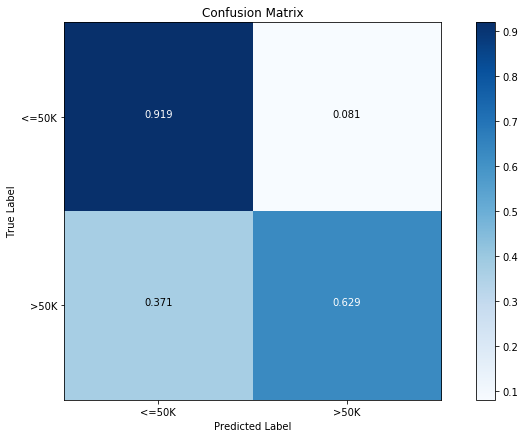

In [24]:
y_pred = rclf.predict(x_test)
cfm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["<=50K", ">50K"], normalize=True)

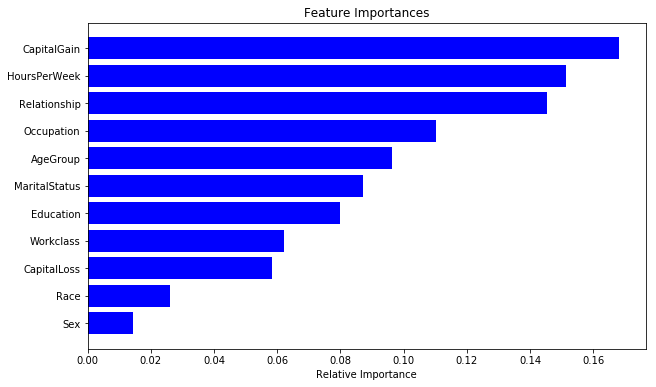

In [25]:
importances = rclf.feature_importances_
indices = np.argsort(importances)
cols = [cols[x] for x in indices]
plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), cols)
plt.xlabel('Relative Importance')

同样采用sklearn中的GridSearchCV()函数进行5折交叉验证来调参。

In [26]:
# 调参时间较长 此处不再运行
# parameters = {
#      'n_estimators':(1000, 1000, 1000),
#      'max_depth':(None, 24, 16),
#      'min_samples_split': (2, 4, 8),
#      'min_samples_leaf': (16, 4, 12)
# }

# clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5, n_jobs=8)
# clf.fit(x_train, y_train)
# clf.best_score_, clf.best_params_

86.35833179780111%


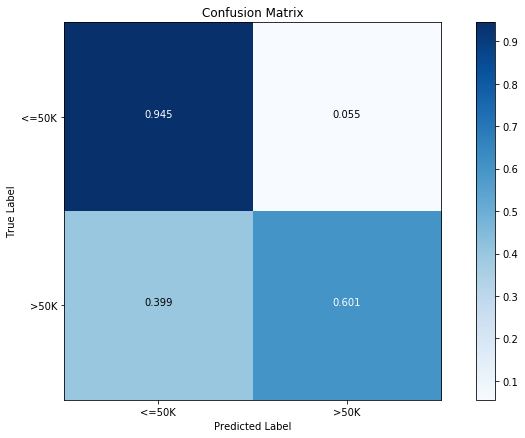

In [27]:
# 直接选择最优参数的随机森林
rclf2 = RandomForestClassifier(n_estimators=1000,max_depth=24,min_samples_leaf=4,min_samples_split=8)
rclf2.fit(x_train, y_train)

rf2_score = rclf2.score(x_test, y_test)
print('{0}%'.format(rf2_score*100))

y_pred = rclf2.predict(x_test)
cfm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["<=50K", ">50K"], normalize=True)

调参后的随机森林分类正确率提升至**86.31%**，但高收入群体的分类正确率反而出现了下降。

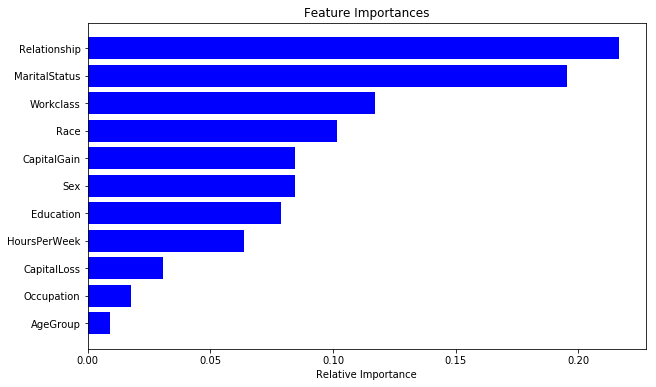

In [28]:
importances = rclf2.feature_importances_
indices = np.argsort(importances)
cols = [cols[x] for x in indices]
plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), cols)
plt.xlabel('Relative Importance')

由上图可看出，两个随机森林的特征重要性差别很大，这也是随机森林的一个主要问题，即模型方差较大，不同模型对应完全不同的解释。